In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tqdm import tqdm
%matplotlib inline

import time
from datetime import date, timedelta

from google.oauth2.service_account import Credentials
import logging

from oauth2client.service_account import ServiceAccountCredentials

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2

In [3]:
# GBQ logging
import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [30]:
from lifelines.utils import datetimes_to_durations
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

In [4]:
# GBQ service account connection
credentials=Credentials.from_service_account_file('C:/Users/mncedisi.mncwabe/Documents/Connect to BQ/tal-production-data-4390ad039b75.json')

In [38]:
start_time = time.time()

query_cust = '''
SELECT DISTINCT customer_id, FY, Auth_Date, FORMAT_DATE("%Y-%m-%d",timestamp_millis(after.DateAdded)) AS DateAdded,
 Division, Department,# Level1,
 Customer_seq,
DATE_DIFF(Auth_Date,Lag,DAY) AS Diff, RepeatPurchase
FROM (
SELECT customer_id, FY, Auth_Date,Division, Department, #Level1, 
Customer_seq,
 LAG(Auth_Date) OVER (PARTITION BY customer_id ORDER BY  Auth_Date) AS Lag,
CASE WHEN customer_seq > 1 THEN 'Repeat Customer'
ELSE 'New Customer'
END AS RepeatPurchase
FROM (
    SELECT  *,
         CASE WHEN DATE(x.Auth_Date) >= '2019-04-01' AND DATE(x.Auth_Date) < '2020-04-01' THEN "FY20"
              WHEN DATE(x.Auth_Date) >= '2020-04-01' AND DATE(x.Auth_Date) < '2021-04-01' THEN "FY21"
              WHEN DATE(x.Auth_Date) >= '2021-04-01' AND DATE(x.Auth_Date) < '2022-04-01' THEN "FY22"
      END AS FY,
    RANK() OVER (PARTITION BY customer_id ORDER BY x.Auth_Date) AS customer_seq
    FROM
(
SELECT  
       DISTINCT customer_id,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        #bh.bh_level_1 AS Level1,
       DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales AS SalesEx,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2010_2020` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2019-04-01" AND DATE(o.order_placed_timestamp) < "2020-01-01" 
        AND DATE(o.order_authed_timestamp) >= "2019-04-01" AND DATE(o.order_authed_timestamp) < "2020-01-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        #AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND o.order_authed_timestamp IS NOT NULL

UNION ALL

SELECT 
        DISTINCT customer_id,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        #bh.bh_level_1 AS Level1,
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales AS SalesEx,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2020-01-01" AND DATE(o.order_placed_timestamp) < "2022-06-01" 
        AND DATE(o.order_authed_timestamp) >= "2020-01-01" AND DATE(o.order_authed_timestamp) < "2022-06-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        #AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND o.order_authed_timestamp IS NOT NULL) x)
WHERE FY='FY22' 
GROUP BY 1,2,3,4,5,6
ORDER BY Auth_Date ASC) p
INNER JOIN `tal-production-data-lakehouse.tal_dl_cdc_mysql_take2.take2_customers` c
       ON p.customer_id = c.after.idCustomer
WHERE RepeatPurchase='New Customer'
GROUP BY 1,2,3,4,5,6,7,8,9
ORDER BY Auth_Date ASC
'''
df_cust= pd.read_gbq(query_cust, project_id='gcp-takealot', dialect='standard', credentials=credentials,progress_bar_type='tqdm_notebook')

print("--- %s seconds ---" % (time.time() - start_time))

Requesting query... 
2022-06-29 11:50:03,624 : DEBUG : Requesting query... 
Query running...
2022-06-29 11:50:06,487 : DEBUG : Query running...
Job ID: cbbc9540-6172-42b7-add4-2281f1620a67
2022-06-29 11:50:06,487 : DEBUG : Job ID: cbbc9540-6172-42b7-add4-2281f1620a67
Query done.
Processed: 0.0 B Billed: 0.0 B
2022-06-29 11:50:06,502 : DEBUG : Query done.
Processed: 0.0 B Billed: 0.0 B
Standard price: $0.00 USD

2022-06-29 11:50:06,507 : DEBUG : Standard price: $0.00 USD



GenericGBQException: Reason: 403 Access Denied: Table tal-production-data-lakehouse:tal_dl_cdc_mysql_take2.take2_customers: User does not have permission to query table tal-production-data-lakehouse:tal_dl_cdc_mysql_take2.take2_customers.

Location: EU
Job ID: cbbc9540-6172-42b7-add4-2281f1620a67


In [12]:
df = pd.read_csv('survival_analysis.csv')

In [13]:
df['T'],df['E'] = datetimes_to_durations(df['DateAdded'], df['Auth_Date'])
df.head()

,customer_id,FY,Auth_Date,DateAdded,Division,Department,Customer_seq,Diff,RepeatPurchase,T,E
0,6484612,FY22,2021-04-01,2020-07-09,Home,DIY & Automotive,1,NaN,New Customer,266.0,True
1,7711813,FY22,2021-04-01,2021-04-01,Consumables,Consumer Beauty,1,NaN,New Customer,0.0,True
2,7714309,FY22,2021-04-01,2021-04-01,Consumables,Baby,1,NaN,New Customer,0.0,True
3,6632890,FY22,2021-04-01,2020-08-08,Electronics,Computer Components,1,NaN,New Customer,236.0,True
4,7702649,FY22,2021-04-01,2021-03-30,Home,Office,1,NaN,New Customer,2.0,True


- The column df[’T’]  is the number of days from creating account to making first purchase
- while df[‘E’] marks if the customer ever purchased.

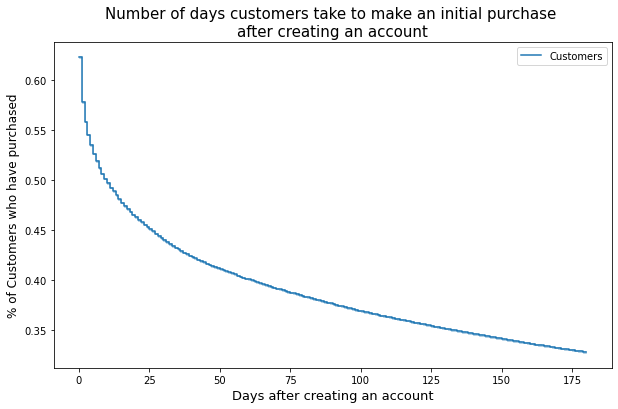

In [29]:
kmf = KaplanMeierFitter(label="Customers")
kmf.fit(df['T'], df['E'])
kmf.plot(figsize=(10,6), loc = slice(0., 180))
plt.title("Number of days customers take to make an initial purchase \nafter creating an account",fontsize=15)
plt.ylabel("% of Customers who have purchased",fontsize=12)
plt.xlabel("Days after creating an account",fontsize=13);

- About 35% of our customers make their first purchase after ~150 days after creating an account with us.
- At least 60% make their first purchase on the same day they create their account

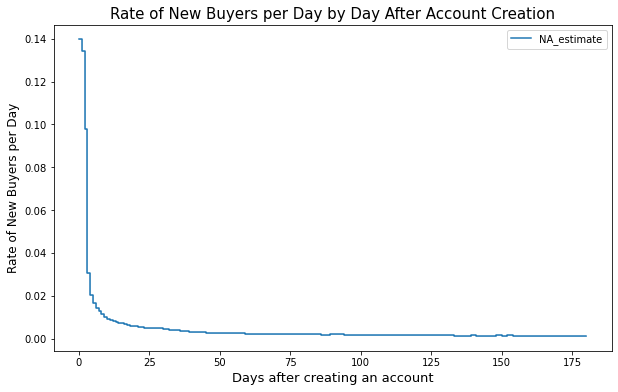

In [35]:
naf = NelsonAalenFitter()
naf.fit(df['T'], event_observed=df['E'])
naf.plot_hazard(figsize=(10,6), bandwidth=3, loc=slice(0., 180))
plt.title('Rate of New Buyers per Day by Day After Account Creation',fontsize=15)
plt.xlabel("Days after creating an account",fontsize=13);
plt.ylabel('Rate of New Buyers per Day',fontsize=12);

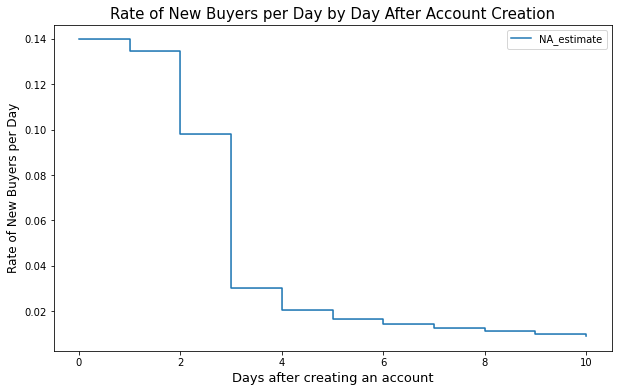

In [37]:
# Around day 0 and 1 we have the highest rate of new buyers creating accounts

naf = NelsonAalenFitter()
naf.fit(df['T'], event_observed=df['E'])
naf.plot_hazard(figsize=(10,6), bandwidth=3, loc=slice(0., 10))
plt.title('Rate of New Buyers per Day by Day After Account Creation',fontsize=15)
plt.xlabel("Days after creating an account",fontsize=13);
plt.ylabel('Rate of New Buyers per Day',fontsize=12);